In [52]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn 
import tensorflow as tf
from tensorflow.keras import preprocessing
from keras import layers
from keras import models
from IPython import display

In [53]:
# setting up the data directory
DATA_DIR="dataset/cats_dogs"

# setting up path for train and test data
train_dir=DATA_DIR+"/train"
test_dir=DATA_DIR+"/test"

In [54]:
# get the train files
file_train = tf.io.gfile.glob(train_dir + '/*/*')
# shuffle 
file_train = tf.random.shuffle(file_train)

train_ds=file_train

# get the test files
file_test = tf.io.gfile.glob(test_dir + '/*/*')
# shuffle 
file_test = tf.random.shuffle(file_test)


test_ds=file_test
print("Shape of train data:- ", train_ds.shape)
print("Shape of test data:- ",file_test.shape)

Shape of train data:-  (210,)
Shape of test data:-  (67,)


In [55]:
# Function to get waveform and it's label
def get_waveform_label(file):
  # get the label
  lab = tf.strings.split(file, os.path.sep)[-2]
  # read the binalry file 
  audio_binary = tf.io.read_file(file)
  # decode the file 
  audio, _ = tf.audio.decode_wav(audio_binary)
  # sqeeze tha audio
  waveform=tf.squeeze(audio, axis=-1)
  return waveform, lab

# get waveforms and labels of all files
AUTO = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_ds)
waveform_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)

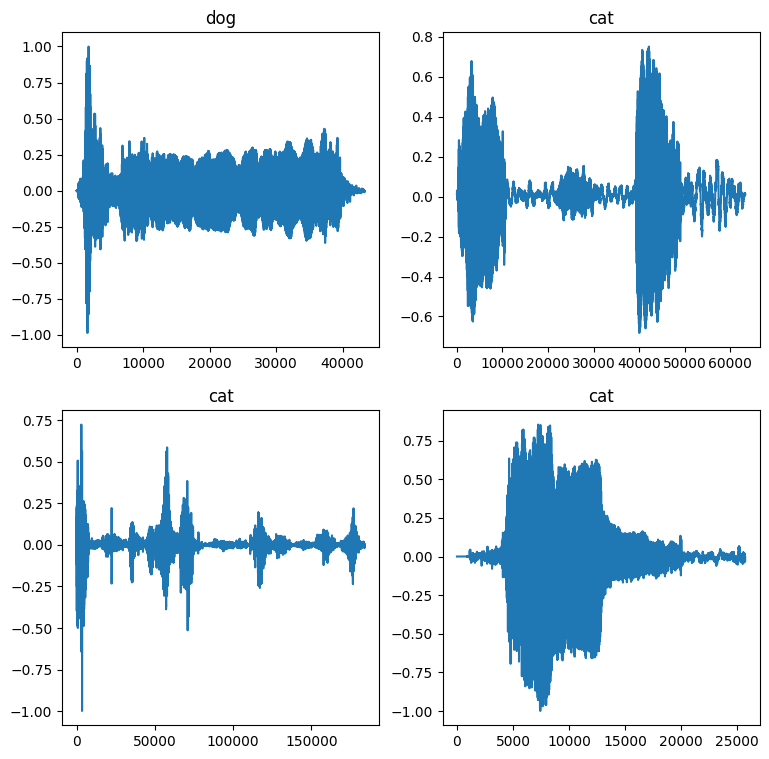

In [56]:
# number of rows and columns of plot
row,col = 2,2
n = row*col
fig, axs = plt.subplots(row, col, figsize=(9, 9))

# plotting waveforms
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // col
  c = i % col
  ax = axs[r][c]
  ax.plot(audio.numpy())

  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [57]:
# function to get the spectogram and the labels
def get_spectrogram_label(audio, label):
  # apply padding
  padding = tf.zeros([300000] - tf.shape(audio), dtype=tf.float32)
  # get the spectogram of the audio
  wave = tf.cast(audio, tf.float32)
  eq_length = tf.concat([wave, padding], 0)
  spectrogram = tf.signal.stft(
      eq_length, frame_length=210, frame_step=110)    
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, -1)
  # get associated label of the audio
  label_id = tf.argmax(label == labels)
  # return the spectogram and the label
  return spectrogram, label_id

# get all the labels from the dataset   
labels = np.array(["cat","dog"])

# get the labels and spectogram
spectrogram_ds = waveform_ds.map(
    get_spectrogram_label, num_parallel_calls=AUTO)

C:\Users\jhona\AppData\Local\Temp\ipykernel_3304\1159814392.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


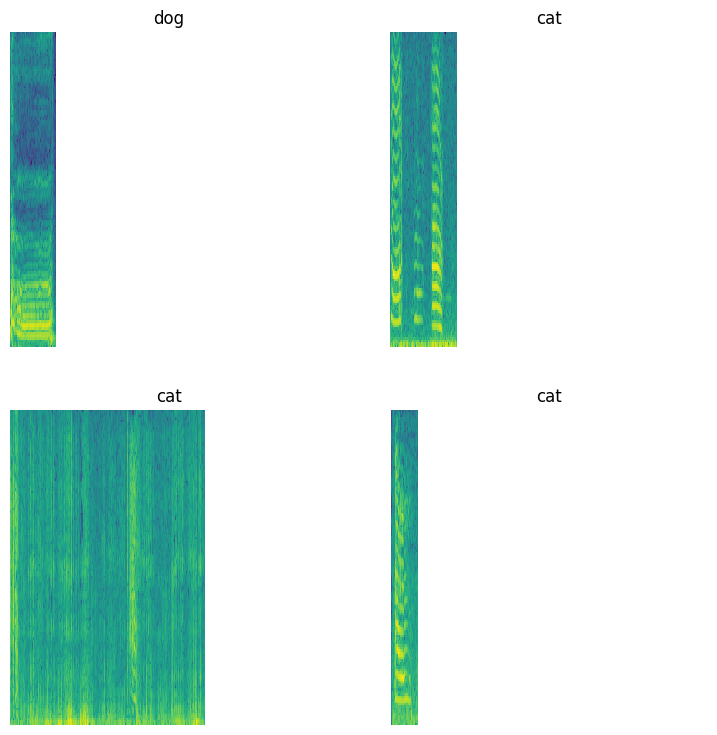

In [58]:
# function to plot the spectogram
def plot_spect(spectrogram, ax):
  # Converting frequencies to log and transpose to repesent time on x axis
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

# plot using a subplot
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # function call
  plot_spect(np.squeeze(spectrogram.numpy()), ax)
  # set the title label
  ax.set_title(labels[label_id.numpy()])
  ax.axis('off')
plt.show()

In [59]:
# function to preprocess the data
def preprocess(file):
  files_ds = tf.data.Dataset.from_tensor_slices(file)
  # get waveforms and labels
  output_ds = files_ds.map(get_waveform_label, num_parallel_calls=AUTO)
  # get spectogram and labels
  output_ds = output_ds.map(
      get_spectrogram_label,  num_parallel_calls=AUTO)
 # return the data
  return output_ds

# train test and validate data
train_ds = spectrogram_ds

test_ds = preprocess(test_ds)

In [60]:
# initialize a batch size
batch_size = 64
# batch train and validate data
train_ds = train_ds.batch(batch_size)
# cache and prefetch the data
train_ds = train_ds.cache().prefetch(AUTO)

In [61]:
# building the model
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(labels)
# normalize adapt 
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# adding layers
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (2726, 129, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)         │          3 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_12 (Conv2D)              │ (None, 22, 22, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_13 (Conv2D)              │ (None, 20, 20, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 18, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │    524,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 2)                 │        258 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 598,981 (2.28 MB)

 Trainable params: 598,978 (2.28 MB)

 Non-trainable params: 3 (16.00 B)

In [62]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [63]:
EPOCHS = 10
history = model.fit(
    train_ds,  
    epochs=EPOCHS,
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.4741 - loss: 0.6934
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5919 - loss: 0.6815
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5996 - loss: 0.6751
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5996 - loss: 0.6858 
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5996 - loss: 0.6728
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5996 - loss: 0.6701 
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5996 - loss: 0.6671 
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5966 - loss: 0.6644 
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6068 - loss: 0.6684 
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6210 - loss: 0.6640 


In [64]:
# initialize empty list to save the audio and labels
t_audio = []
t_labels = []

# load in the labels and audio from test dataset
for audio, label in test_ds:
  t_audio.append(audio.numpy())
  t_labels.append(label.numpy())

# convert the lists to a numpy array
t_audio = np.array(t_audio)
t_labels = np.array(t_labels)

In [65]:
# Feed in the data for prediction
y_pred = np.argmax(model.predict(t_audio), axis=1)

# store the original labels for testing the accuracy
y_true = t_labels

# get the testing accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Test set accuracy: 88%


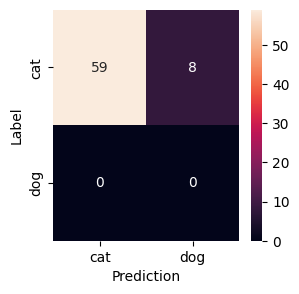

In [66]:
conf_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(3,3))
seaborn.heatmap(conf_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix,accuracy_score
confusion_matrix(y_true,y_pred)

array([[59,  8],
       [ 0,  0]], dtype=int64)

In [68]:
accuracy_score(y_true,y_pred)

0.8805970149253731